Copied from this page: https://umap-learn.readthedocs.io/en/latest/basic_usage.html

    conda create -n umap -c conda-forge -c anaconda jupyterlab numpy pandas scikit-learn seaborn matplotlib umap-learn

# How to Use UMAP

UMAP is a general purpose manifold learning and dimension reduction algorithm. It is designed to be compatible with scikit-learn, making use of the same API and able to be added to sklearn pipelines. If you are already familiar with sklearn you should be able to use UMAP as a drop in replacement for t-SNE and other dimension reduction classes. If you are not so familiar with sklearn this tutorial will step you through the basics of using UMAP to transform and visualise data.

First we’ll need to import a bunch of useful tools. We will need numpy obviously, but we’ll use some of the datasets available in sklearn, as well as the train_test_split function to divide up data. Finally we’ll need some plotting tools (matplotlib and seaborn) to help us visualise the results of UMAP, and pandas to make that a little easier.

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import umap

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

%matplotlib inline

In [2]:
sns.set(style='ticks', context='notebook', rc={'figure.figsize':(9,7)})


## Penguin data

The next step is to get some data to work with. To ease us into things we’ll start with the penguin dataset. It isn’t very representative of what real data would look like, but it is small both in number of points and number of features, and will let us get an idea of what the dimension reduction is doing.

In [3]:
penguins = pd.read_csv("https://github.com/allisonhorst/palmerpenguins/raw/5b5891f01b52ae26ad8cb9755ec93672f49328a8/data/penguins_size.csv")
penguins.head()

species_short     island  culmen_length_mm  culmen_depth_mm  \
0        Adelie  Torgersen              39.1             18.7   
1        Adelie  Torgersen              39.5             17.4   
2        Adelie  Torgersen              40.3             18.0   
3        Adelie  Torgersen               NaN              NaN   
4        Adelie  Torgersen              36.7             19.3   

   flipper_length_mm  body_mass_g     sex  
0              181.0       3750.0    MALE  
1              186.0       3800.0  FEMALE  
2              195.0       3250.0  FEMALE  
3                NaN          NaN     NaN  
4              193.0       3450.0  FEMALE

Since this is for demonstration purposes we will get rid of the NAs in the data; in a real world setting one would wish to take more care with proper handling of missing data.

In [4]:
penguins = penguins.dropna()
penguins.species_short.value_counts()

Adelie       146
Gentoo       120
Chinstrap     68
Name: species_short, dtype: int64

See the github repostiory for more details about the dataset itself. It consists of measurements of bill (culmen) and flippers and weights of three species of penguins, along with some other metadata about the penguins. In total we have 334 different penguins measured. Visualizing this data is a little bit tricky since we can’t plot in 4 dimensions easily. Fortunately four is not that large a number, so we can just to a pairwise feature scatterplot matrix to get an ideas of what is going on. Seaborn makes this easy.

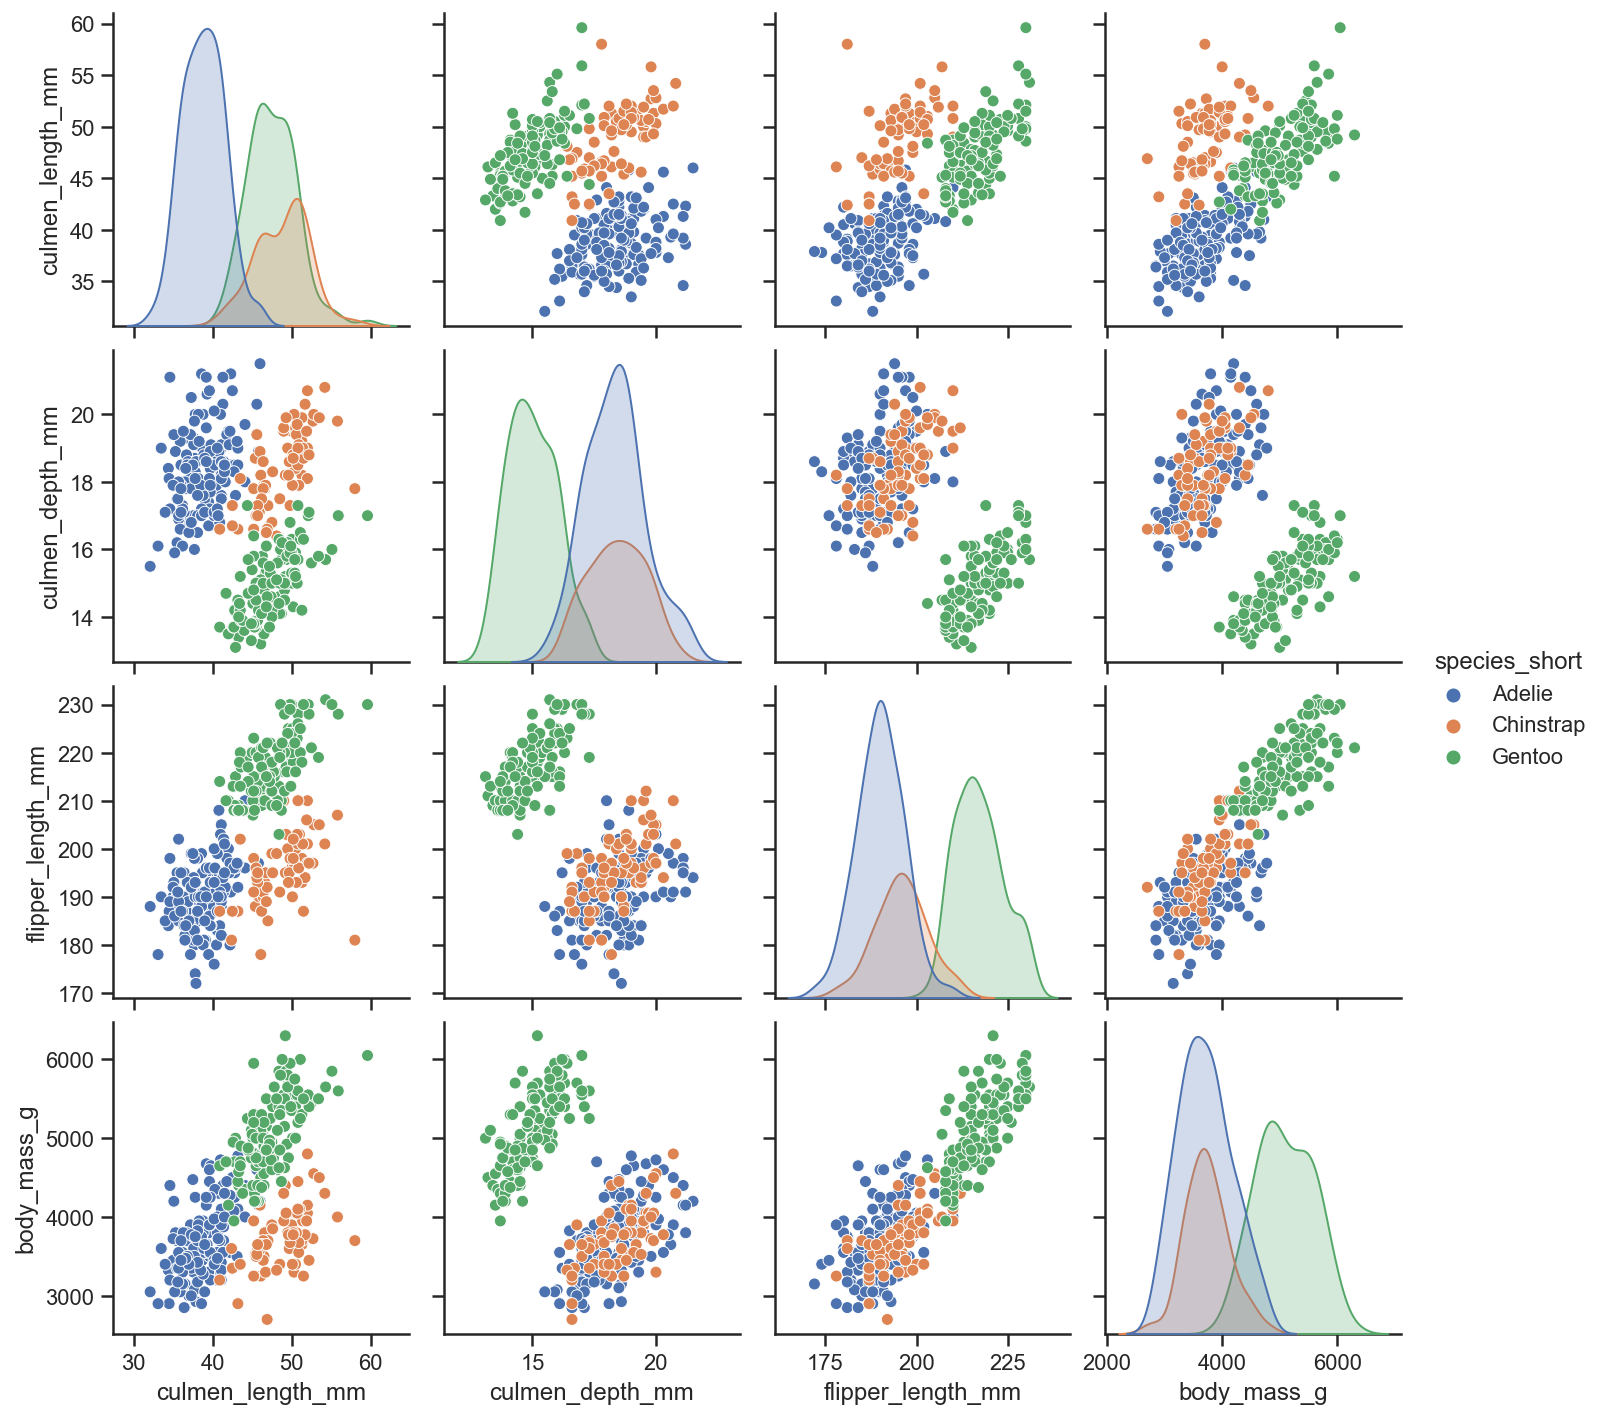

In [5]:
sns.pairplot(penguins, hue='species_short')


This gives us some idea of what the data looks like by giving as all the 2D views of the data. Four dimensions is low enough that we can (sort of) reconstruct what the full dimensional data looks like in our heads. Now that we sort of know what we are looking at, the question is what can a dimension reduction technique like UMAP do for us? By reducing the dimension in a way that preserves as much of the structure of the data as possible we can get a visualisable representation of the data allowing us to “see” the data and its structure and begin to get some intuition about the data itself.

To use UMAP for this task we need to first construct a UMAP object that will do the job for us. That is as simple as instantiating the class. So let’s import the umap library and do that.

In [6]:
reducer = umap.UMAP()

Before we can do any work with the data it will help to clean up it a little. We won’t need NAs, we just want the measurement columns, and since the measurements are on entirely different scales it will be helpful to convert each feature into z-scores (number of standard deviations from the mean) for comparability.

In [7]:
penguin_data = penguins[
    [
        "culmen_length_mm",
        "culmen_depth_mm",
        "flipper_length_mm",
        "body_mass_g",
    ]
].values
scaled_penguin_data = StandardScaler().fit_transform(penguin_data)

Now we need to train our reducer, letting it learn about the manifold. For this UMAP follows the sklearn API and has a method fit which we pass the data we want the model to learn from. Since, at the end of the day, we are going to want to reduced representation of the data we will use, instead, the fit_transform method which first calls fit and then returns the transformed data as a numpy array.

In [8]:
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

(334, 2)

The result is an array with 334 samples, but only two feature columns (instead of the four we started with). This is because, by default, UMAP reduces down to 2D. Each row of the array is a 2-dimensional representation of the corresponding penguin. Thus we can plot the embedding as a standard scatterplot and color by the target array (since it applies to the transformed data which is in the same order as the original).

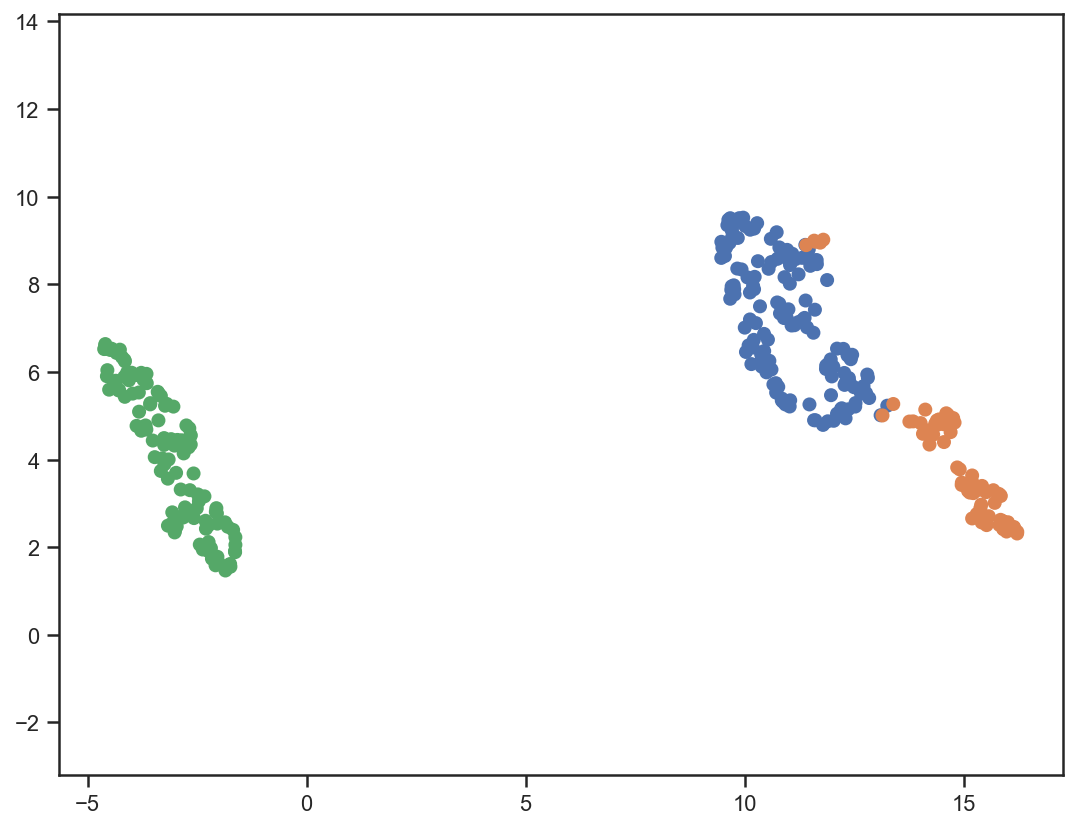

In [9]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
plt.gca().set_aspect('equal', 'datalim')

This does a useful job of capturing the structure of the data, and as can be seen from the matrix of scatterplots this is relatively accurate. Of course we learned at least this much just from that matrix of scatterplots – which we could do since we only had four different dimensions to analyse. If we had data with a larger number of dimensions the scatterplot matrix would quickly become unwieldy to plot, and far harder to interpret. So moving on from the Penguin dataset, let’s consider the digits dataset.

## Digits data

First we will load the dataset from sklearn.

In [10]:
digits = load_digits()
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

We can plot a number of the images to get an idea of what we are looking at. This just involves matplotlib building a grid of axes and then looping through them plotting an image into each one in turn.

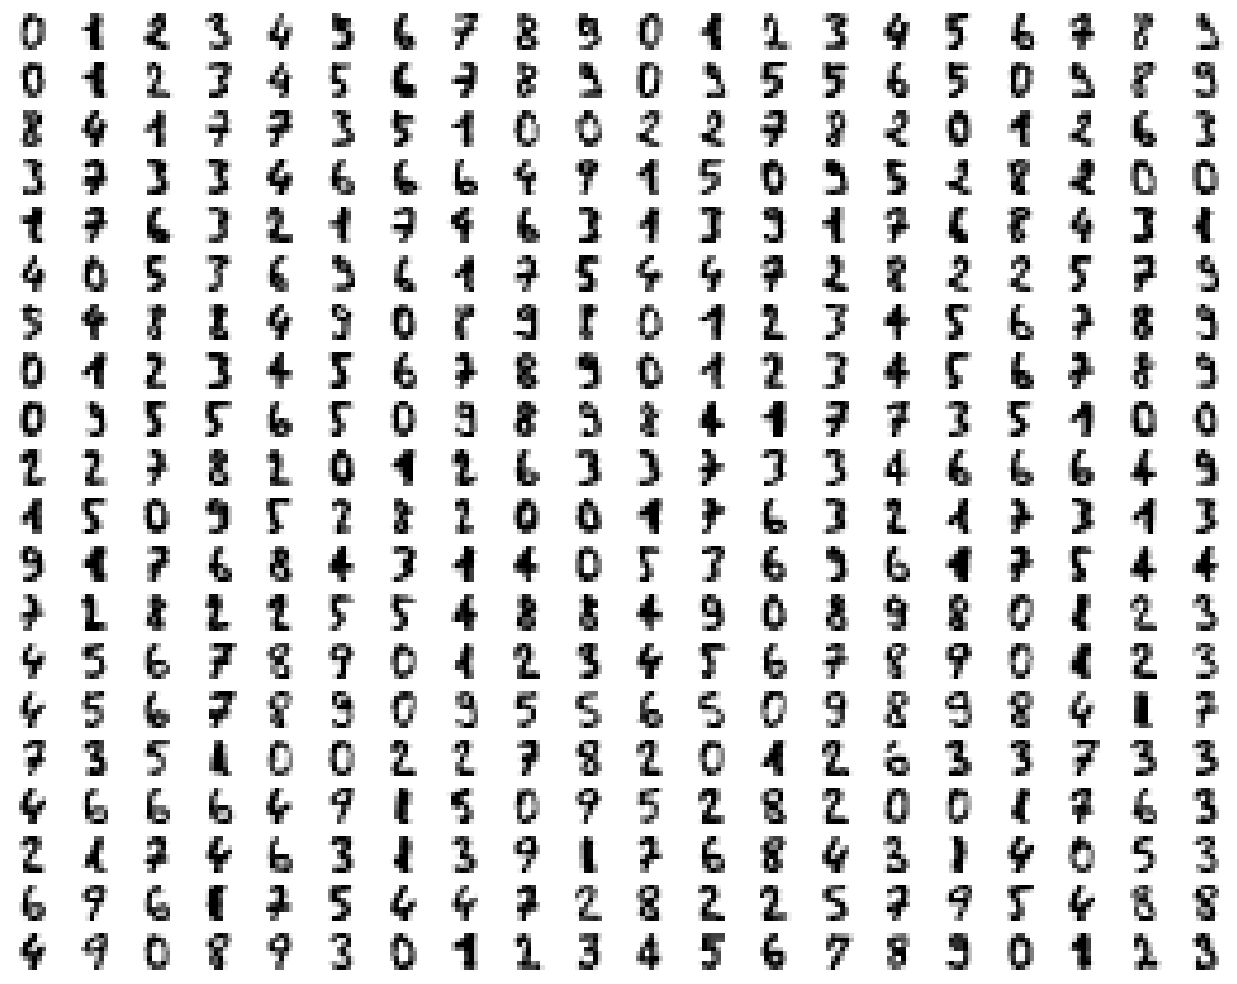

In [11]:
fig, ax_array = plt.subplots(20, 20)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    ax.imshow(digits.images[i], cmap='gray_r')
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.5, w_pad=0.01)

As you can see these are quite low resolution images – for the most part they are recognisable as digits, but there are a number of cases that are sufficiently blurred as to be questionable even for a human to guess at. The zeros do stand out as the easiest to pick out as notably different and clearly zeros. Beyond that things get a little harder: some of the squashed thing eights look awfully like ones, some of the threes start to look a little like crossed sevens when drawn badly, and so on.

Each image can be unfolded into a 64 element long vector of grayscale values. It is these 64 dimensional vectors that we wish to analyse: how much of the digits structure can we discern? At least in principle 64 dimensions is overkill for this task, and we would reasonably expect that there should be some smaller number of “latent” features that would be sufficient to describe the data reasonably well. We can try a scatterplot matrix – in this case just of the first 10 dimensions so that it is at least plottable, but as you can quickly see that approach is not going to be sufficient for this data.

/Users/kmt/miniconda3/envs/umap/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/kmt/miniconda3/envs/umap/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/kmt/miniconda3/envs/umap/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/kmt/miniconda3/envs/umap/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/kmt/miniconda3/envs/umap/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/kmt/miniconda3/envs/umap/lib/python3.8/site-packages/

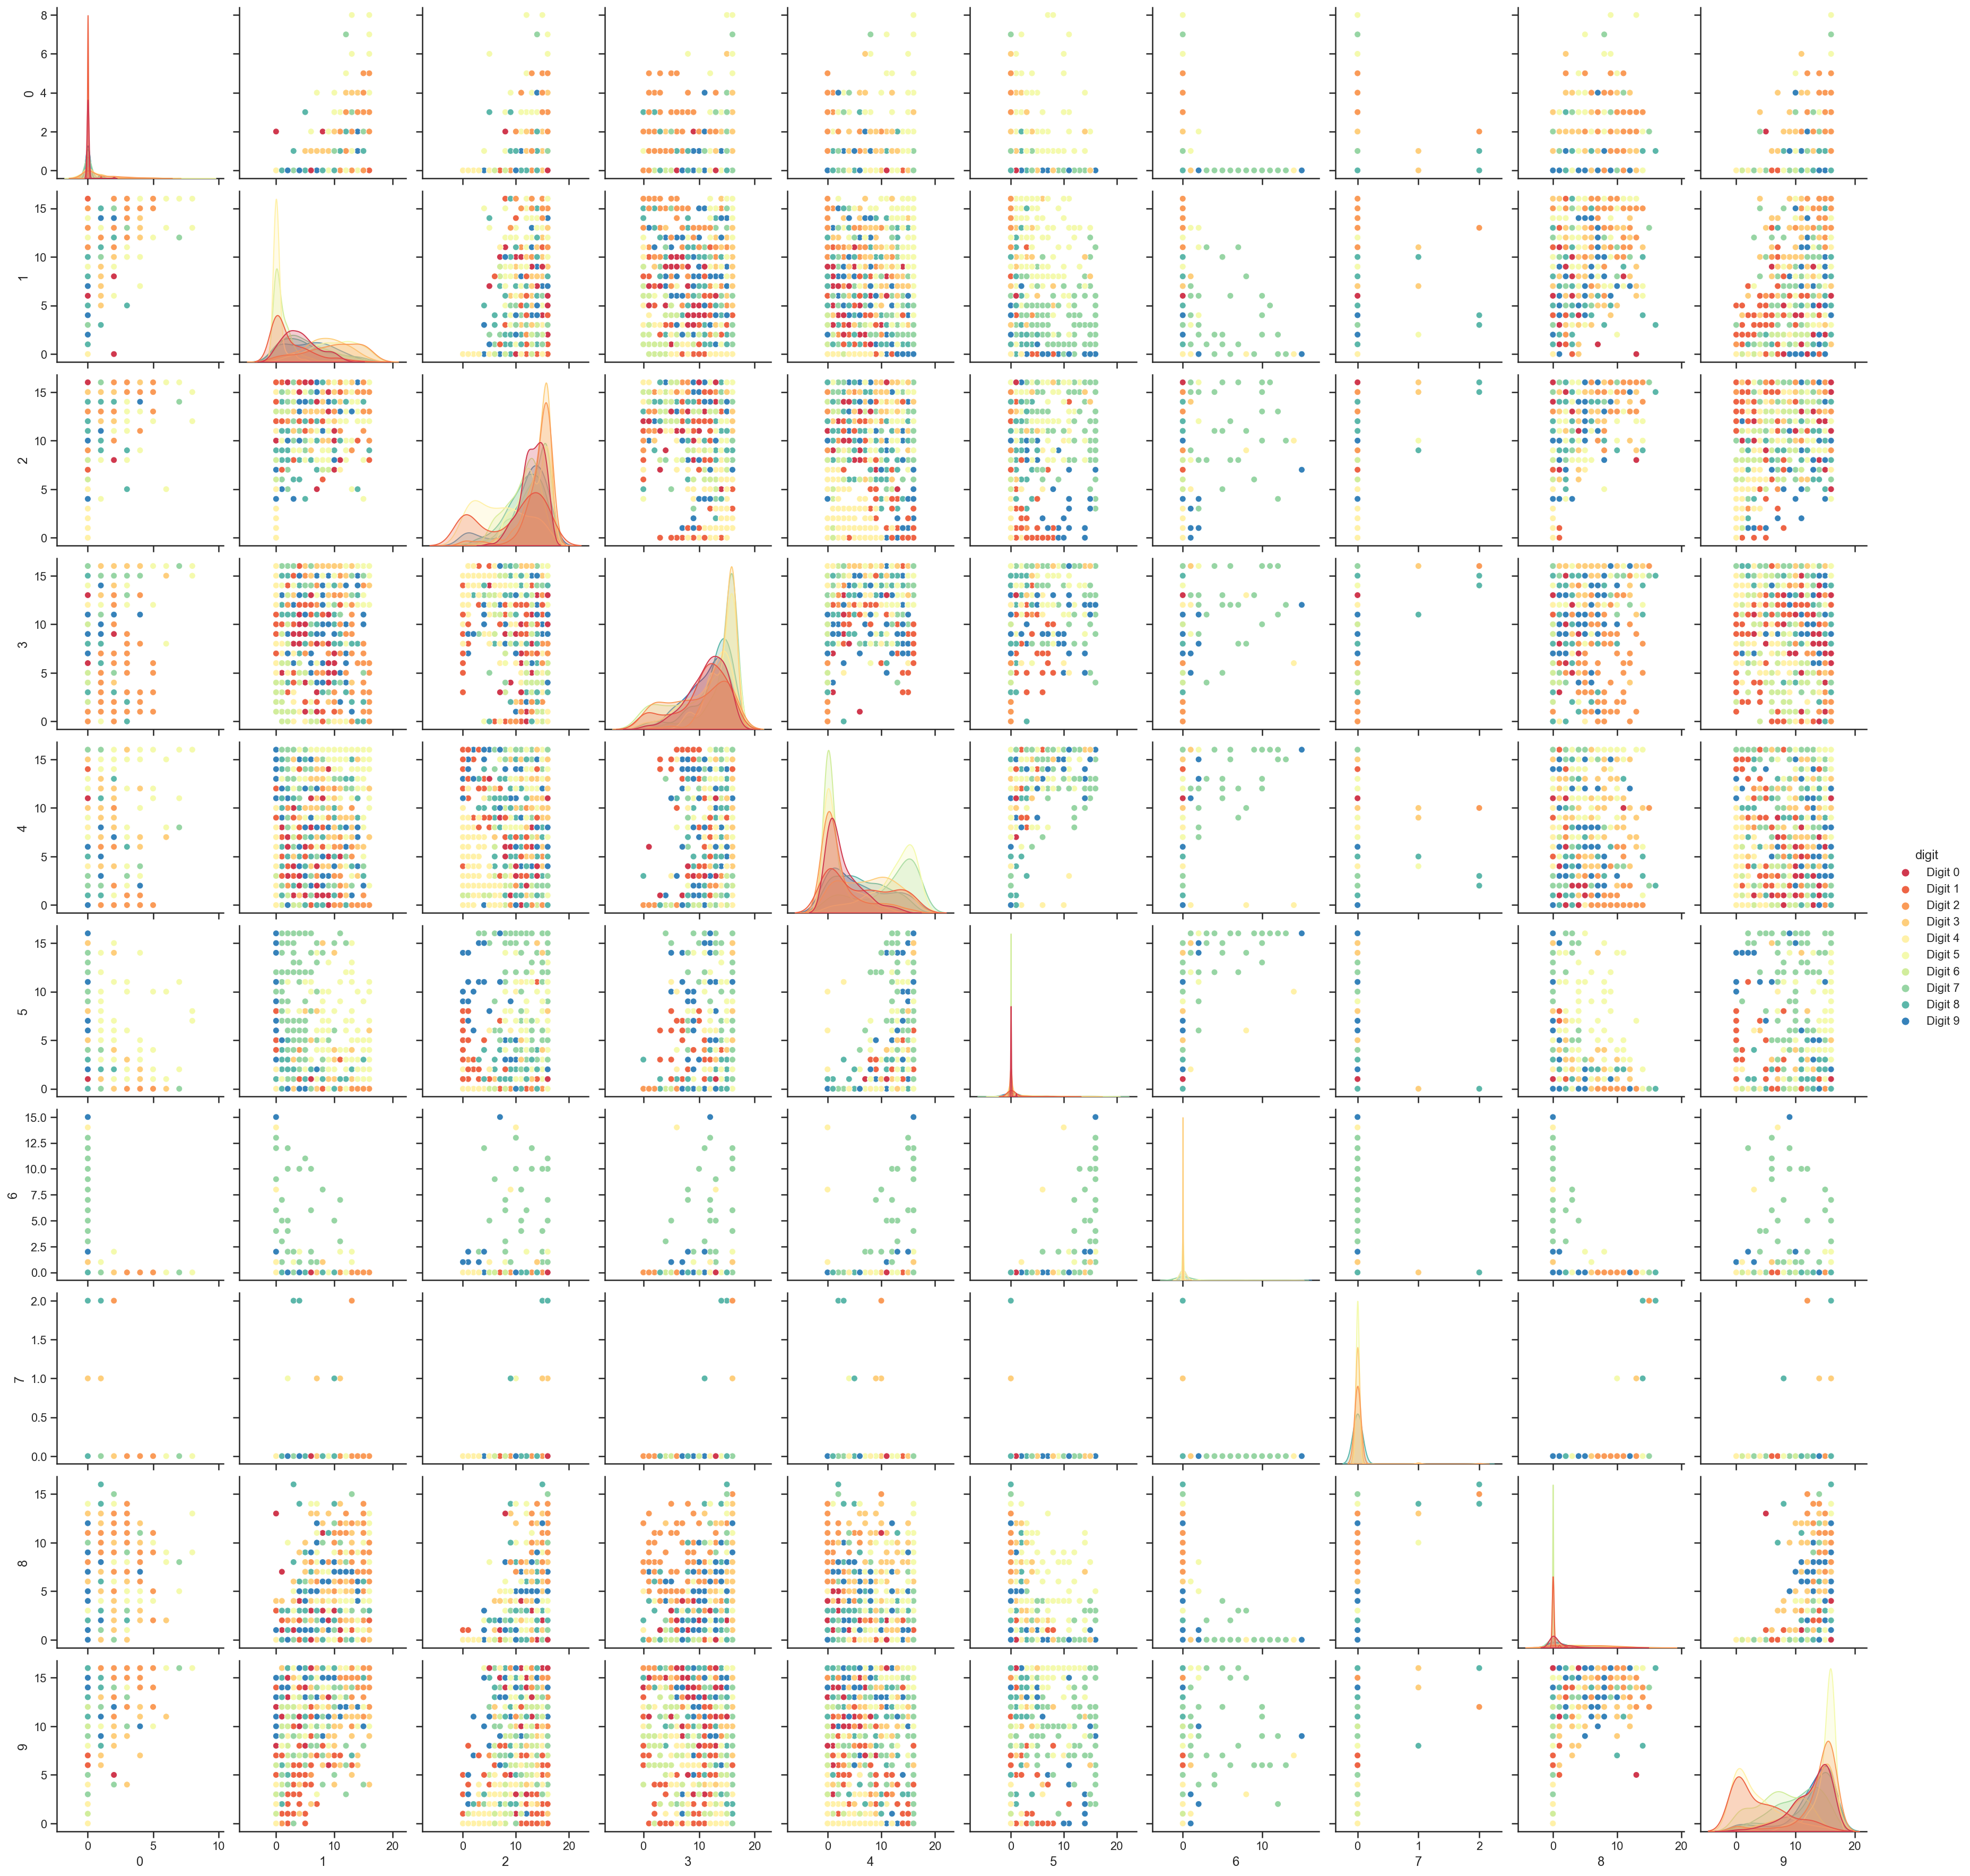

In [12]:
digits_df = pd.DataFrame(digits.data[:,1:11])
digits_df['digit'] = pd.Series(digits.target).map(lambda x: 'Digit {}'.format(x))
sns.pairplot(digits_df, hue='digit', palette='Spectral')

In contrast we can try using UMAP again. It works exactly as before: construct a model, train the model, and then look at the transformed data. To demonstrate more of UMAP we’ll go about it differently this time and simply use the fit method rather than the fit_transform approach we used for Penguins.

In [13]:
reducer = umap.UMAP(random_state=42)
reducer.fit(digits.data)

UMAP(dens_frac=0.0, dens_lambda=0.0, random_state=42)

Now, instead of returning an embedding we simply get back the reducer object, now having trained on the dataset we passed it. To access the resulting transform we can either look at the embedding_ attribute of the reducer object, or call transform on the original data.

In [14]:
embedding = reducer.transform(digits.data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(1797, 2)

We now have a dataset with 1797 rows (one for each hand-written digit sample), but only 2 columns. As with the Penguins example we can now plot the resulting embedding, coloring the data points by the class that they belong to (i.e. the digit they represent).

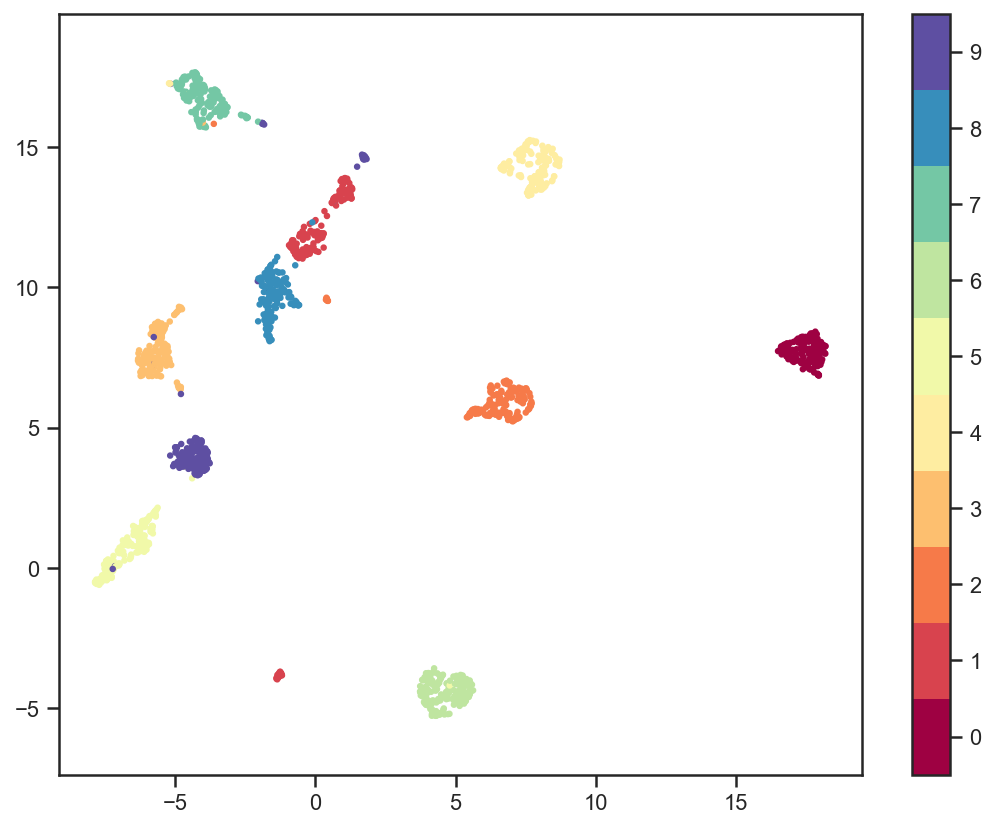

In [15]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=digits.target, cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

We see that UMAP has successfully captured the digit classes. There are also some interesting effects as some digit classes blend into one another (see the eights, ones, and sevens, with some nines in between), and also cases where digits are pushed away as clearly distinct (the zeros on the right, the fours at the top, and a small subcluster of ones at the bottom come to mind). To get a better idea of why UMAP chose to do this it is helpful to see the actual digits involve. One can do this using bokeh and mouseover tooltips of the images.

First we’ll need to encode all the images for inclusion in a dataframe.

In [17]:
reducer = umap.UMAP(random_state=42, n_components=3)
reducer.fit(digits.data)


UMAP(dens_frac=0.0, dens_lambda=0.0, n_components=3, random_state=42)

In [18]:
embedding = reducer.transform(digits.data)
# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

(1797, 3)

In [21]:
#%matplotlib widget

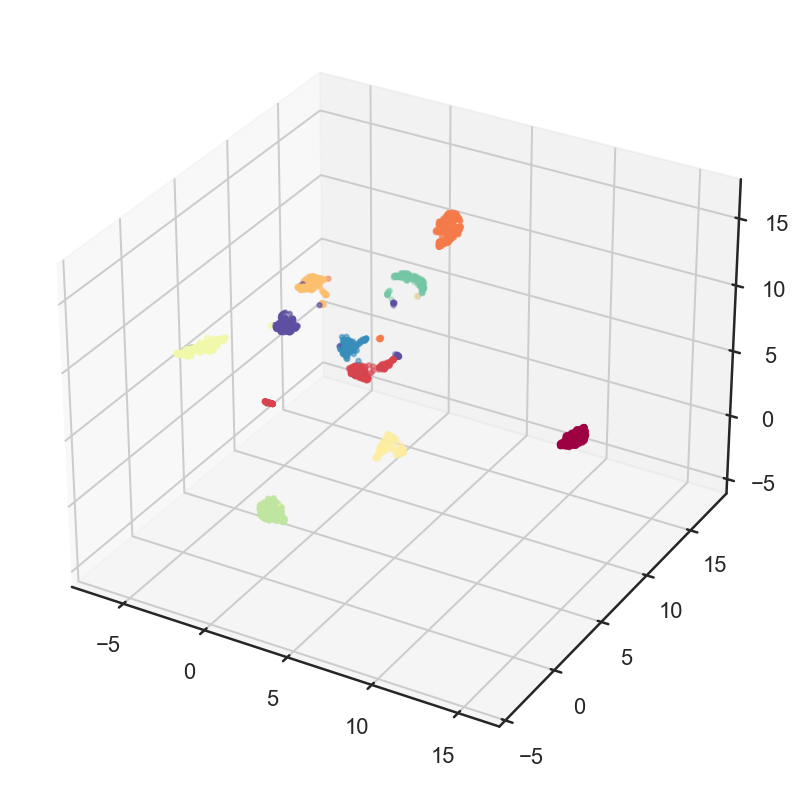

In [28]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=digits.target, cmap='Spectral', s=5)

